Copyright Rigetti Computing 2021.

### QAOA using PyQuil

Import relevant modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import itertools

import numpy as np

from pyquil import Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
from pyquil.paulis import *

from tqdm import tqdm

import networkx as nx

Specify resources: For now, let's use the `WavefunctionSimulator` for simulating our algorithm.

In [2]:
wfn_sim = WavefunctionSimulator()

Let's try and solve the simplest problem we can think of: the 2-node graph. Its MaxCut solution should just be the cut across the lone edge in the graph. Expressed as a bitstring, the solution is either `01` or `10`. Let's see if we can get this solution using QAOA.

First, we need to specify the qubits we will use.

In [3]:
qubits = [0, 1]
n_qubits = len(qubits)

The 2-node graph on these qubits looks like this.

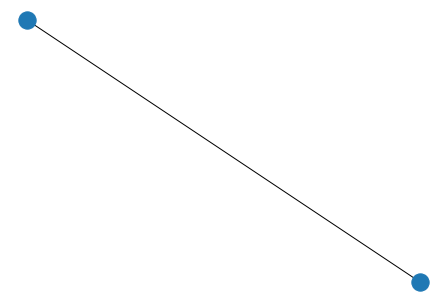

In [4]:
G = nx.Graph()
G.add_edge(qubits[0], qubits[1])
nx.draw(G)

Specifying the Cost Hamiltonian for this problem is simple. It is just the product of Z operators on the 2 nodes (qubits). For our purposes, we can simply optimize $\sum ZZ$ insteadd of the MaxCut Hamiltonian $\frac{1}{2} \sum I - Z_i Z_j$. The main difference is that we will now seek to minimize rather than maximize the hamiltonian.

In [5]:
# Cost hamiltonian of the 2-node graph connecting qubits 0 and 1
qA, qB = qubits
hamiltonian = sZ(qA) * sZ(qB) + 0.0

Specifying the mixer term is also simple. We just need the sum of all `X`s on all the qubits.

In [6]:
mixer = sX(qA) + sX(qB)

Let's now write our first QAOA program. We'll focus on the `p=1` case.

In [7]:
# Initialize an empty Program
qaoa_prog = Program()

# Declare some parametric variables 
gamma = qaoa_prog.declare('gamma', 'REAL', 1)
beta = qaoa_prog.declare('beta', 'REAL', 1)

# Initial state
for q in qubits:
    qaoa_prog += H(q)
    
# Cost term
for ham_term in hamiltonian:
    qaoa_prog += exponential_map(ham_term)(gamma)
    
# Mixer term
for mixer_term in mixer:
    qaoa_prog += exponential_map(mixer_term)(beta)

Let's take a peek at what a typical QAOA state looks like.

In [8]:
gamma, beta = np.random.uniform(0.0, 2*np.pi, size=2)
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [gamma], 'beta': [beta]})
print(wfn)

(-0.3829318021-0.4181104428j)|00> + (0.2741963852-0.3215015317j)|01> + (0.2741963852-0.3215015317j)|10> + (-0.3829318021-0.4181104428j)|11>


Notice and compare the amplitudes for $\vert 00 \rangle$ and $\vert 11 \rangle$, or $\vert 01 \rangle$ or $\vert 10 \rangle$. Are they the same or different? Why or why not?

Using the same values for `gamma` and `beta`, let's compute what the expectation value of the cost hamiltonian would look like, which is what we're trying to optimize for, after all.

In [9]:
expect = wfn_sim.expectation(qaoa_prog, hamiltonian, memory_map={'gamma': [gamma], 'beta': [beta]})
print(expect)

0.28581242973026794


Is this a good or bad solution? We can find out by comparing against the true result. Since we are interested in the least possible value that the cost hamiltonian operator can take over all possible quantum states, we can solve for the eigenvalues of the matrix corresponding to this operator.

In [10]:
from pyquil.simulation.tools import lifted_pauli

# obtain the matrix form of the cost hamiltonian operator
mat = lifted_pauli(hamiltonian, hamiltonian.get_qubits())

# obtain its eigenvalues
eigvals, eigvecs = np.linalg.eig(mat)
min_eigval = np.min(eigvals)
assert np.isclose(min_eigval.imag, 0.0)   # expectation value of a Hermitian observable should be real
min_eigval = np.real(min_eigval)
print(f"Min eigenvalue: {min_eigval}")

Min eigenvalue: -1.0


Let's now perform an entire scan over possible values of `gamma` and `beta`, and find the best possible angles, the min expectation value, and crucially, the bitstrings we sample for the optimal values of `gamma` and `beta`.

In [11]:
width = 25
angle_range = np.linspace(0.0, np.pi, width)

expectations = []

expect_min = np.inf
best_angles = None

for (gamma, beta) in tqdm(list(itertools.product(angle_range, angle_range))):
    expect = wfn_sim.expectation(qaoa_prog, hamiltonian, memory_map={'gamma': [gamma], 'beta': [beta]})
    expectations.append(expect)
    
    if expect < expect_min:
        expect_min = expect
        best_angles = (gamma, beta)
    
landscape = np.array(expectations).reshape(width, width)

100%|██████████| 625/625 [00:03<00:00, 175.15it/s]


Let's plot what the landscape looks like.

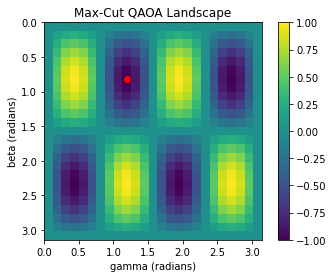

In [12]:
min_x, min_y = (np.argmin(landscape) % width, np.argmin(landscape) // width)
plt.imshow(landscape, extent=[0, np.pi, np.pi, 0])
plt.plot((min_x + 0.5) * np.pi / width, (min_y + 0.5) * np.pi / width, 'ro')
plt.colorbar()
plt.xlabel('gamma (radians)')
plt.ylabel('beta (radians)')
plt.title(f'Max-Cut QAOA Landscape')
plt.show()

Here are the optimal values of `gamma` and `beta` that produce the best value for the cost hamiltonian.

In [13]:
opt_gamma, opt_beta = best_angles
print(f"Optimal gamma: {opt_gamma}")
print(f"Optimal beta: {opt_beta}")

Optimal gamma: 0.7853981633974483
Optimal beta: 1.1780972450961724


Let's see what the `p=1` QAOA state looks like for these values.

In [14]:
wfn = wfn_sim.wavefunction(qaoa_prog, memory_map={'gamma': [opt_gamma], 'beta': [opt_beta]})
print(wfn)

(-0.5-0.5j)|01> + (-0.5-0.5j)|10>


You should observe a non-zero amplitude only for the states $\vert 10\rangle$ and $\vert 01 \rangle$. Thus, if we sample from this state, we should only obtain the MaxCut solution, which specifies a cut across the single edge in the graph.

In [15]:
samples = wfn.sample_bitstrings(n_samples=10)
print(samples)

[[0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]]


Moreover, if we compare the expectation value of the cost hamiltonian to the min eigenvalue of its corresponding matrix, we should find a ratio of exactly 1.

In [16]:
opt_expect = wfn_sim.expectation(qaoa_prog, hamiltonian, memory_map={'gamma': [opt_gamma], 'beta': [opt_beta]})
performance_ratio = np.abs(opt_expect) / np.abs(min_eigval)
print(f"Performance ratio: {performance_ratio}")

Performance ratio: 0.999999999999999


We could also have utilized some other optimizer to find the optimum.

In [17]:
from scipy.optimize import minimize

In [18]:
def objective(angles):
    global wfn_sim
    global qaoa_prog
    global hamiltonian
    gamma, beta = angles
    obs = wfn_sim.expectation(qaoa_prog, hamiltonian, memory_map={'gamma': [gamma], 'beta': [beta]})
    return obs

In [19]:
initial_guess = np.random.uniform(0.0, np.pi, size=2)
res = minimize(objective, x0=initial_guess, method='COBYLA')

print(f"Optimization completed: {res.success}")
print(f"Performance ratio: {-res.fun}")
print(f"Optimal angles: {res.x}")

Optimization completed: True
Performance ratio: 0.9999998493377515
Optimal angles: [2.35616052 1.96335923]
